# 1. Introduction
[NASA HI-SEAS](https://hi-seas.org/) missions act as a testbed and training ground for humans as we develop the capability to explore Mars. 
A recent NASA Space Apps Challenge hackathon asked participants to use data collected from the HI-SEAS site to predict solar radiation given a set of measurable meteorological conditions.
Knowing when conditions are most favorable for incident solar radiation is crucial for deciding when and where to deploy solar energy harvesting equipment, especially for colonists or astronauts on the surface of Mars.

The original Kaggle dataset & competition can be found here: https://www.kaggle.com/dronio/SolarEnergy

## 1.1. Scenario
We are participants in a NASA HI-SEAS (Hawai’i Space Exploration Analog and Simulation) mission, simulating a human settlement on Mars. 

A large solar array and battery bank are installed at the settlement and are the only power source available.
On sunny days, the array collects enough energy to power the entire settlement and recharge the battery bank.
The battery bank is used (sparingly) at night and on overcast days.
There is a strict power budget for operations each day to make sure vital equipment stays online, and we also have a number of experiments to run.

We have been collecting data at our settlement since the end of the last HI-SEAS mission in September, 2016.
It is now January, 2017, and our mission is about to begin.

Can we model solar radiation as a function of the information our sensors can gather, based on previously collected data?

## 1.2. About this dataset
These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) is useful in sorting this export's results The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results The date in `yyyy-mm-dd` format The local time of day in `hh:mm:ss` 24-hour format The numeric data, if any (may be an empty string) The text data, if any (may be an empty string)

The units of each dataset are:

* Solar radiation: watts per meter^2
* Temperature: degrees Fahrenheit
* Humidity: percent
* Barometric pressure: Hg
* Wind direction: degrees
* Wind speed: miles per hour
* Sunrise/sunset: Hawaii time

## 1.3. About this kernel
The purpose of this kernel is to explore this dataset and apply basic machine learning techniques in order to predict solar radiation given a set of weather conditions.

__Assumptions__
* In an application of this model, predicted meterological data (hourly temperature and humidity, for example) would be used as inputs (rather than using the model as a true predictor).
* Effects of rain and cloud cover are neglected, except those which are indirectly measured by temperature, pressure, and humidity.
* The sun angle with regard to the solar array is neglected. While it could be derived from the location of HI-SEAS and date-time data, this adds too much complexity to the problem for now.

This is my first foray into the world of data science and machine learning (ML). 
As such, it is expected that the following code will not be optimized for memory, runtime, or readability.
However, the result is still expected to be at worst interesting, at most useful.

I have decided to use Python 3 since it is widely used for data science, a versatile and useful language (even outside of data processing and ML), and a new language to me -- I'd like the practice.

## 1.4. Thanks
I would like to thank the following groups and individuals for providing the tutorials, resources, and inspiration to conduct this study.
* [NASA & Kaggle](https://www.kaggle.com/dronio/SolarEnergy), for providing this dataset.
* [sentdex on YouTube](https://www.youtube.com/playlist?list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v), for his incredible series on machine learning and everything else Python.
* Sarah Linden, for encouraging me to do engineering projects in my free time.

# 2. Preprocessing the data
Before applying any machine learning techniques, the input data must be ingested and conditioned.
Not all the data provided is useful!

## 2.1. Defining Features and Labels
Machine learning algorithms operate on _features_ to predict _labels_.

* A __feature__ is an attribute of the system that affects the output. 
Features act as "inputs" to the model.
Ideally, features are _independent_ variables.
* A __label__ is the value being predicted. 
Labels act as "outputs" of the model.

Now, let's consider our scenario. 
Recall the available data:
* Date
* Time of Day 
* Solar Radiation
* Temperature
* Pressure
* Humidity
* Wind Direction
* Wind Speed
* Time at Sunrise
* Time at Sunset

### 2.1.1. Features
At every timestamp within each day, there are values for all other variables.
No other variables impact the values of time or date.
Therefore __date__ and __time of day__ are _independent_ variables.

For each date, there is _one_ value for `Time at Sunrise` and `Time at Sunset`. 
The difference of these values yields the length of a given day, which is directly related to the date.
More exploration of the dataset is needed to determine if the length of a given date supersedes `date` in the amount of useful information it provides.

Temperature, pressure, and humidity do not directly affect one another significantly, but since they are all properties which describe the local atmosphere, they do not vary independently from one another.
Similarly, all three of these variables have a stong relationship to time of day. 

Therefore we consider the following variables to be _features_ to the machine learning algorithm:
* Date (or Length of Day)
* Time of day
* Temperature
* Pressure
* Humidity
* Wind Speed
* Wind Direction

Further exploration of the dataset may modify this list, but for now this is our best guess.

### 2.1.2. Labels
The goal is to model solar radiation based on the available features, so it makes sense for `radiation` to be the algorithm's label. 
Recorded radiation measurements serve as the truth values to train and test the supervised machine learning algorithm.

## 2.2. Importing the Data
First, all of the data is loaded in as the appropriate data types.
The column `Data` contains a single, unchanging timestamp. This appears to be the dat the dataset was published, but that is unclear.
For our purposes, this is not useful information and the column is removed from the dataset.

Time of day, sunrise, and sunset values are converted to `datetime` objects which are stored as timezone naive UNIX time values (we can always translate it back later).

In [10]:
## IMPORT LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pytz # timezones

def ingest_data(filename):
    '''Read data from a CSV file and construct a pandas DataFrame
    Inputs:
        filename as string
    Outputs:
        df as DataFrame
    '''
    # read csv file
    df = pd.read_csv(filename)

    # 'Data' column is unused. All elements contain the same value.
    # 'Time' is redundant and superseded by UNIXTime.
    df.drop(['Data','Time'],axis=1,inplace=True)

    # interpret columns as appropriate data types to ensure compatibility
    df['UNIXTime']      = pd.to_datetime(df['UNIXTime'],unit='s')
    df['Radiation']     = df['Radiation'].astype(float)
    df['Temperature']   = df['Temperature'].astype(float) # or int
    df['Pressure']      = df['Pressure'].astype(float)
    df['Humidity']      = df['Humidity'].astype(int) # or int
    df['WindDirection(Degrees)'] = df['WindDirection(Degrees)'].astype(float)
    df['Speed']         = df['Speed'].astype(float)
    df['TimeSunRise']   = pd.to_datetime(df['TimeSunRise'],format='%H:%M:%S')
    df['TimeSunSet']    = pd.to_datetime(df['TimeSunSet'],format='%H:%M:%S')
    df.rename(columns={'WindDirection(Degrees)': 'WindDirection', 'Speed': 'WindSpeed'}, inplace=True)

    # compute length of each day
    df['DayLength'] = (df['TimeSunSet']-df['TimeSunRise'])/np.timedelta64(1, 's')

    # we don't need sunrise or sunset times anymore, so drop them
    df.drop(['TimeSunRise','TimeSunSet'],axis=1,inplace=True)

    # index by UNIX time
    df.sort_values('UNIXTime', inplace=True) # sort by UNIXTime
    df.set_index('UNIXTime',inplace=True) # index by UNIXTime

    # Localize the index (using tz_localize) to UTC (to make the Timestamps timezone-aware) and then convert to Eastern (using tz_convert)
    hawaii=pytz.timezone('Pacific/Honolulu')
    df.index=df.index.tz_localize(pytz.utc).tz_convert(hawaii)

    # assign unit labels to data keys
    units={'Radiation':'W/m^2','Temperature':'F','Pressure':'in Hg','Humidity':'\%','DayLength':'sec'}
    return df, units

In [11]:
df, units = ingest_data('input/SolarPrediction.csv')
print(df.head())

                           Radiation  Temperature  Pressure  Humidity  \
UNIXTime                                                                
2016-09-01 00:00:08-10:00       2.58         51.0     30.43       103   
2016-09-01 00:05:10-10:00       2.83         51.0     30.43       103   
2016-09-01 00:20:06-10:00       2.16         51.0     30.43       103   
2016-09-01 00:25:05-10:00       2.21         51.0     30.43       103   
2016-09-01 00:30:09-10:00       2.25         51.0     30.43       103   

                           WindDirection  WindSpeed  DayLength  
UNIXTime                                                        
2016-09-01 00:00:08-10:00          77.27      11.25    45060.0  
2016-09-01 00:05:10-10:00         153.44       9.00    45060.0  
2016-09-01 00:20:06-10:00         142.04       7.87    45060.0  
2016-09-01 00:25:05-10:00         144.12      18.00    45060.0  
2016-09-01 00:30:09-10:00          67.42      11.25    45060.0  


Note that the `Time` column is dropped in favor of the `UNIXTime` timestamp. 
UNIX time encodes both date and time, so the `Time` column is redundant.
UNIX time is converted from UTC to Hawaii Standard Time, then data is sorted by UNIX time.

## 2.3. Exploring the Data
Plotting libraries are imported to visualize data.
Then each measurement is visualized and Pearson correlations are calculated to determine which parameters have the most impact on one another.

In [12]:
## IMPORT LIBRARIES
import numpy as np # linear algebra
from scipy import stats # statistics
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting tools
import seaborn as sns # advanced plotting tools
sns.set(style="white")

# make IPython render plots inline
%matplotlib inline 

First, a basic correlation matrix is generated to weed out irrelevant data and identify the most significant features in the set.

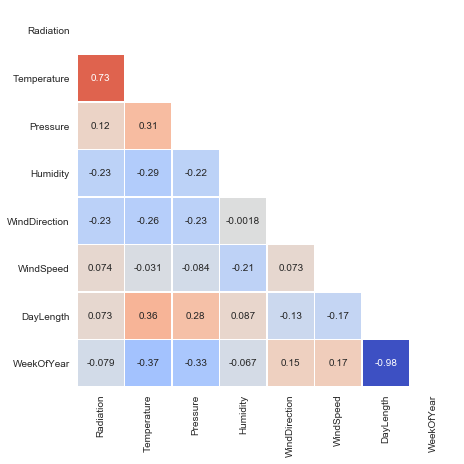

In [13]:
def corrPairs(df):
    '''Pairwise correlation matrix'''
    corr = df.corr() # Compute the correlation matrix
    mask = np.zeros_like(corr, dtype=np.bool) # make mask
    mask[np.triu_indices_from(mask)] = True # mask upper triangle
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, square=True, linewidths=.5, annot=True, cbar=False)

df['WeekOfYear'] = df.index.week # add week to view correlation
plt.figure(figsize=(7,7))
corrPairs(df)

Examining the stronger correlations more closely:

In [14]:
def corrfunc(x, y, **kws):
    '''add pearsonr correlatioin to plots'''
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),xy=(.1, .9), xycoords=ax.transAxes, color='white')
    return

def corrMap(df,features):
    '''plot bivariate correlations'''
    g = sns.PairGrid(df, vars=features)
    g.map_upper(plt.scatter, s=10)
    g.map_diag(sns.distplot, kde=False)
    g.map_lower(sns.kdeplot, cmap="coolwarm", shade=True, n_levels=30)
    g.map_lower(corrfunc)
    g.map_lower(corrfunc)

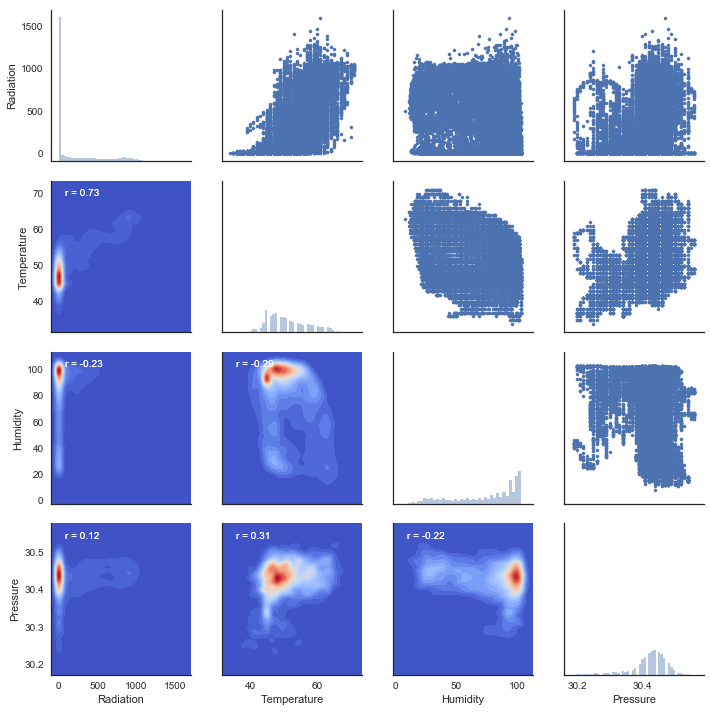

In [15]:
feature_list=['Radiation','Temperature','Humidity','Pressure']
# bivariate density matrix
corrMap(df,feature_list)
plt.show()

There are several timescales to consider in this dataset:
* Monthly
* Daily
* Hourly

Looking into data by the minute is too granular to draw broad conclusions at this stage, but something to be considered when constructing the prediction algorithm.

Radiation is expected vary with the date due to seasonal weather changes. 
The dataset only contains data from autumn and winter, so the model developed from this data may be less capable of predicting radiation during the summer. 
Fortunately, the seasonal climate at the HI-SEAS facility in Hawai'i is fairly consistent year-round.

Recalling the most correlated features, we plot Radiation as a function of Temperature, Humidity, and Pressure on the various timescales.

In [16]:
def color_y_axis(ax, color):
    '''Color y axis on two-axis plots'''
    for t in ax.get_yticklabels():
        t.set_color(color)
    ax.yaxis.label.set_color(color)
    return None

def plotVs(df,timescale,feature1,feature2,ax1,units):
    '''Plot feature vs radiation'''
    ax2=ax1.twinx()
    df_grouped= df.groupby(timescale)

    df_feature1 = df_grouped[feature1].mean()
    df_feature1_errorpos =  df_feature1+df_grouped[feature1].std()/2
    df_feature1_errorneg =  df_feature1-df_grouped[feature1].std()/2
    ax1.plot(df_feature1)
    ax1.fill_between(df_feature1.index, df_feature1_errorpos.values, df_feature1_errorneg.values, alpha=0.3, antialiased=True)
    ax1.set_ylabel(feature1+' '+units[feature1])
    color_y_axis(ax1, 'b')

    if feature2 == 'Radiation':
        rad = df_grouped['Radiation'].mean()
        ax2.plot(rad,'r')
        ax2.fill_between(df_feature1.index, 0, rad, alpha=0.3, antialiased=True, color='red')
        ax2.set_ylabel('Radiation'+' '+units['Radiation'])
        color_y_axis(ax2, 'r')
    else:
        df_feature2 = df_grouped[feature2].mean()
        df_feature2_errorpos =  df_feature2+df_grouped[feature2].std()/2
        df_feature2_errorneg =  df_feature2-df_grouped[feature2].std()/2
        ax1.plot(df_feature2)
        ax1.fill_between(df_feature2.index, df_feature2_errorpos.values, df_feature2_errorneg.values, alpha=0.3, antialiased=True)
        ax1.set_ylabel(feature2+' '+units[feature2])
        color_y_axis(ax1, 'g')
    return ax1, ax2

def HourlyWeeklyVs(df,feature1,feature2,units):
    '''Plot a feature vs radiation for time of day and week of year'''
    plt.figure(figsize=(18, 6))
    ax=plt.subplot(121) # hourly
    ax1,ax2 = plotVs(df,df.index.hour,feature1,feature2,ax,units)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2)
    plt.xlabel('Hour of Day (Local Time)')
    plt.title('Mean Hourly {0} vs. Mean Hourly {1}'.format(feature1,feature2))

    ax=plt.subplot(122) # weekly
    ax1, ax2 = plotVs(df,pd.Grouper(freq='W'),feature1,feature2,ax,units)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2)
    plt.xlabel('Week of Year')
    plt.title('Mean Weekly {0} vs. Mean Weekly {1}'.format(feature1,feature2))
    return


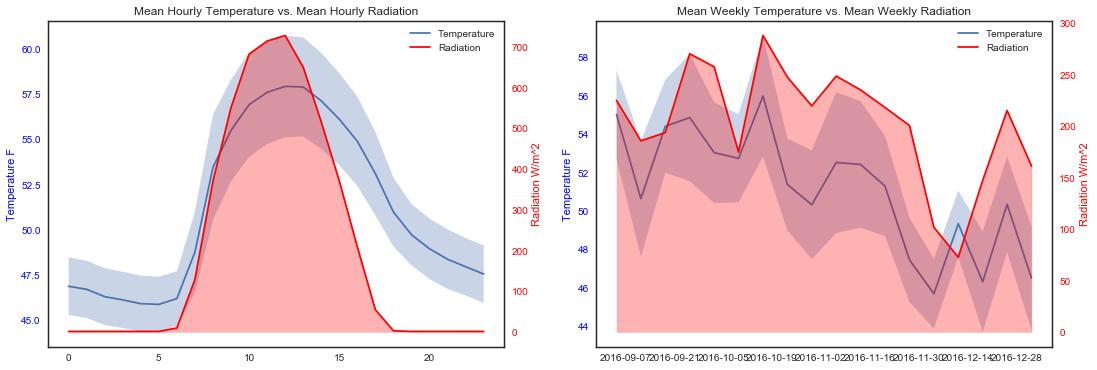

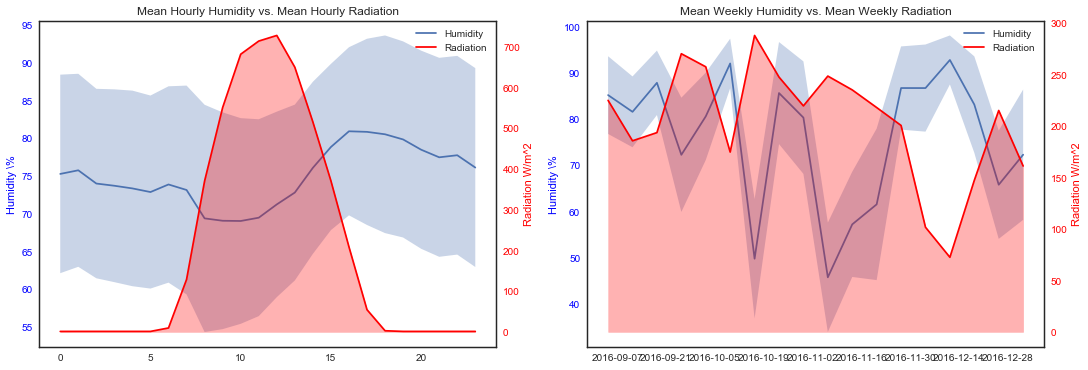

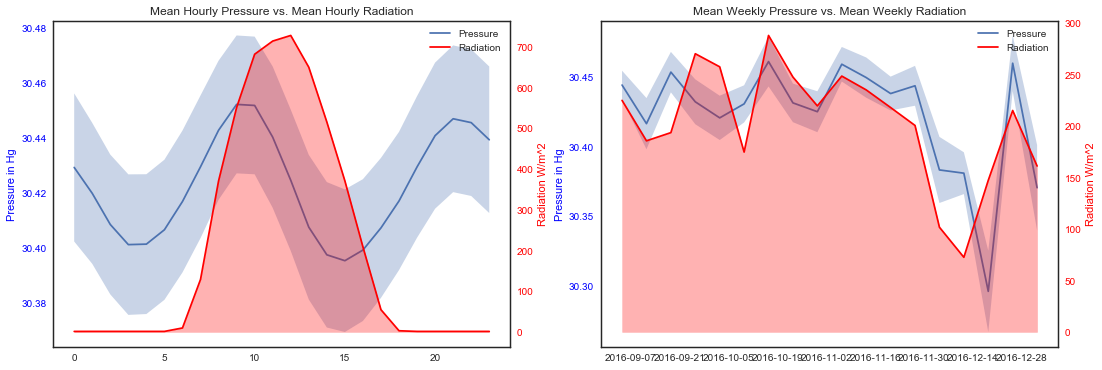

In [17]:
for feature in feature_list[1:]: # radiation vs feature
    HourlyWeeklyVs(df,feature,feature_list[0],units)
plt.show()

## 2.4. Thoughts So Far
From this exploration of the data, we see the following patterns in this dataset:
* __Higher temperatures correlate to more radiation throughput.__ This is confirmed by a Pearson R-value of 0.73 and the observed behavior of radiation "following" temperature on the daily and weekly time scales.
* __Humidity has a lesser (but potentially significant) impact on radiation throughput.__ With a Pearson R-value of magnitude above 0.20, humidity cannot be ignored as a potential driver of the system. Evidence for the negative correlation between the two features is found on the weekly time scale.
* __Pressure doesn't correlate much to radiation, but does correlate to temperature and humidity.__ Weather, basically. Since temperature, pressure, and humidity are all characteristics of the atmosphere it is not surprising that they are correlated.
* __Wind speed and direction are not relevant in this analysis.__ Though both are characteristics of local weather, they do not make sense as predictors of radiation. Wind direction has a moderate correlation to temperature (-0.26), pressure (-0.23) and radiation (-0.23) but through engineering judgement we know that this is only _correlation_ and not _causation_.
* __Seasonal changes are significant.__ Even though Hawai'i does not see seasons as drastic as the northern continental United States, seasonal changes in temperature and humidity are still severe enough to be taken into account, as shown by the weekly measurement comparisons.
* __Weekly timescales are the best predictors.__ Month-to-month variation is too broad to capture seasonal changes within a single year. Daily and hourly measurements have quite a bit of noise when looking for seasonal changes. Since day-to-day weather is dominated by temperature, pressure, and humidity (rather than seasonal changes), week of the year is the best indicator of seasonal trends.

In [18]:
df.drop(['WindDirection','WindSpeed'], axis=1, inplace=True) # drop irrelevant features

# 3. Preparing the Prediction Algorithm
We desire an algorithm that will predict values (radiation for a given set of inputs), we have plenty of data to train with, and we have "unlimited" time.
There are many models to choose from, and more than one may be appropriate.

In this analysis, we will try three models and compare their performance to evaluate the best algorithm to predict solar radiation.
* Linear Regression
* Bayesian Neural Network
* Random Forest

Even before we downselect to a specific model, we can prepare a prediction algorithm that takes in our data and makes a prediction.
Using [`scikit learn`](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning), it is easy to swap out different models and maintain the same higher-level structure to the program.

Also, though it is obvious, solar radiation has a strong correlation to time of day. 
We add time of day as a feature so the algorithm can tell day from night. 
As a side effect, this implicitly accounts for sun angle.

In [19]:
df['TimeOfDay'] = df.index.hour # add time of day to correlation